In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import (
    gamma, poisson, linregress, norm, skew, lognorm,
    truncpareto
)
from scipy.stats import invgamma as ig
from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.special import gammainc
from scipy.special import gamma as gf
from scipy.special import beta as bf
from scipy.special import betaln as lnbf
from scipy.special import betainc as regincbf
from scipy.signal import fftconvolve, savgol_filter
import math
import time
import random
import pickle as pkl
from scipy import optimize
from cratersfd import *
import ash
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [68]:
dmin = 2.0
N = 500
area = 1E6
dmax = math.sqrt(area) / 4
synth_d_list = synth_fixed_N(
    N=N, dmin=dmin, dmax=dmax, pf=npf_new_loglog
)
# ds = random.choice(synth_d_list[0])
ds = np.loadtxt('../data/sash_figure_ds.csv', delimiter=',')

Calculation time: 0.00037 seconds
Calculation time: 0.00022 seconds
Calculation time: 0.00024 seconds
Calculation time: 0.00109 seconds
Calculation time: 0.00107 seconds
Calculation time: 0.001 seconds
Calculation time: 0.00101 seconds
Calculation time: 0.00114 seconds
Calculation time: 0.00011 seconds
4e-05 seconds


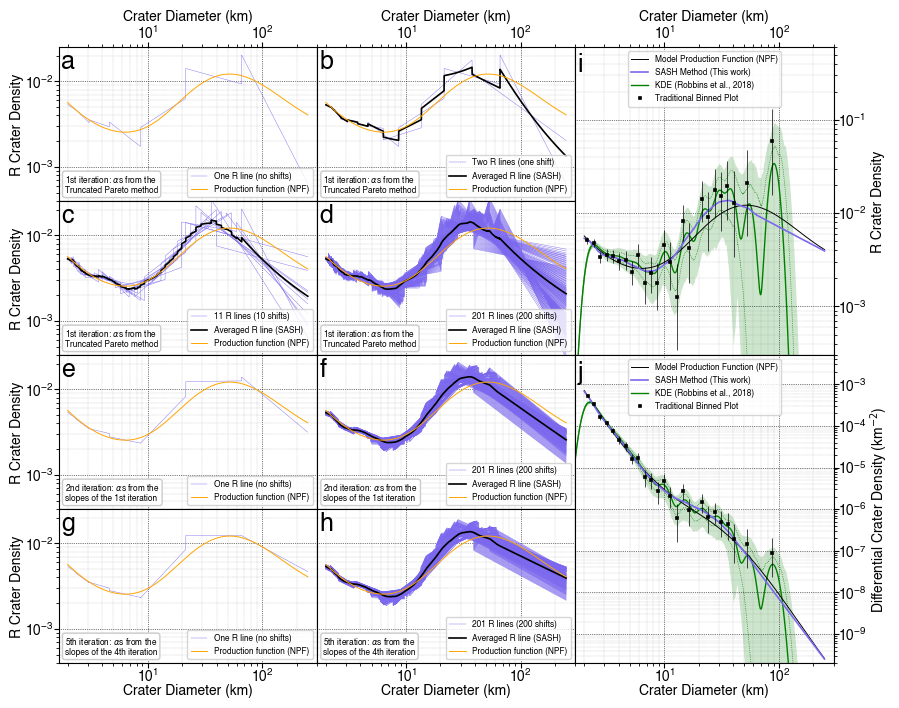

In [11]:
fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(4, 3, figure=fig)

letter_count = 0
def add_letter():
    global letter_count
    plt.text(
        0.01, 0.98, chr(ord('a') + letter_count),
        transform=ax.transAxes, ha='left', va='top',
        size=18
    )
    letter_count += 1

def sash_fig(
    bin_width_exponent=per_decade(18), d_max=dmax, 
    growth_rate=1.3, n_points=10000, n_shifts=200,
    color='black', plot_lines=True, lw=1.2,
    line_color='mediumslateblue', line_lw=0.3,
    min_count=1, n_iterations=0,
    n_alpha_points=1000, plot_error=False,
    fontsize=10, on_top=False, on_right=False,
    n_display_lines=None
):
    X, mean_Y = plot_sash_R(
        ds, area, dmin, 
        **match_kwargs(locals(), plot_sash_R)
    )
    sash_lines = plt.gca().get_lines()
    if len(sash_lines) == 2:
        lines = [sash_lines[0]]
    else:
        lines = [sash_lines[0], sash_lines[-1]]
    plot_npf_R_N(
        ds.size, area, dmin=dmin, dmax=dmax,
        lw=0.7, color='orange'
    )
    lines += plt.gca().get_lines()[-1:]
    if n_display_lines is not None:
        ax_lines = plt.gca().get_lines()
        for ax_line in ax_lines[n_display_lines:-1]:
            ax_line.remove()
        lines = plt.gca().get_lines()
        line_labels = [
            'One R line (no shifts)',
            'Production function (NPF)'
        ]
    elif n_shifts == 1:
        line_labels = [
            'Two R lines (one shift)',
            'Averaged R line (SASH)',
            'Production function (NPF)'
        ]
    else:
        line_labels = [
            (
                str(n_shifts + 1) + ' R lines '
                '(' + str(n_shifts) + ' shifts)'
            ),
            'Averaged R line (SASH)',
            'Production function (NPF)'
        ]
    plt.xlim([dmin / 1.2, dmax * 1.2])
    plt.ylim([4E-4, 2.5E-2])
    if on_right:
        ax.yaxis.labelpad = 3
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    else:
        ax.yaxis.labelpad = 1
    ax.tick_params(axis='both', which='major', pad=0)
    if on_top:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.xaxis.labelpad = 3
    else:
        ax.xaxis.labelpad = -1
    legend = plt.legend(
        lines, line_labels, fontsize=6, loc='lower right'
    )
    iter_str_dict = {
        0 : '1st', 1 : '1st', 2 : '2nd', 3 : '3rd', 
        4 : '4th', 5 : '5th'
    }
    add_letter()

    bbox_dict = {
        'boxstyle' : 'round',
        'edgecolor' : '0.8',
        'facecolor' : 'white',
        'linewidth' : 1
    }

    middle_str = rf' iteration: $\alpha$s from the'
    if n_iterations <= 1:
        method_str = '\nTruncated Pareto method'
    else:
        iter_str = iter_str_dict[n_iterations - 1]
        method_str = '\nslopes of the ' + iter_str + ' iteration'
    plt.text(
        0.025, 0.04,
        iter_str_dict[n_iterations] + middle_str + method_str
        ,
        transform=plt.gca().transAxes, fontsize=6,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=bbox_dict
    )

ax = fig.add_subplot(gs[0, 0])

sash_fig(
    n_shifts=1, color='mediumslateblue', lw=0.3,
    n_display_lines=1, on_top=True
)

ax = fig.add_subplot(gs[0, 1])

sash_fig(n_shifts=1, on_right=True, on_top=True)

ax = fig.add_subplot(gs[1, 0])

sash_fig(n_shifts=10)

ax = fig.add_subplot(gs[1, 1])

sash_fig(n_shifts=200, on_right=True)

ax = fig.add_subplot(gs[2, 0])

sash_fig(
    n_shifts=200, color='mediumslateblue', lw=0.3,
    n_display_lines=1, n_iterations=2
)

ax = fig.add_subplot(gs[2, 1])

sash_fig(n_shifts=200, on_right=True, n_iterations=2)

ax = fig.add_subplot(gs[3, 0])

sash_fig(
    n_shifts=200, color='mediumslateblue', lw=0.3,
    n_display_lines=1, n_iterations=5
)

ax = fig.add_subplot(gs[3, 1])

sash_fig(n_shifts=200, on_right=True, n_iterations=5)

ax = fig.add_subplot(gs[:2, 2])

plot_kde_R(
    ds, area, d_min=1.0, color='green', lw=1.0,
    plot_error=True
)
plot_npf_R_N(
    ds.size, area, dmin=dmin, dmax=dmax,
    lw=0.7, color='black'
)
X, mean_Y = plot_sash_R(
    ds, area, dmin, 
    bin_width_exponent=per_decade(18), 
    d_max=dmax, 
    growth_rate=1.3, n_points=10000, n_shifts=200,
    color='mediumslateblue', plot_lines=False, lw=1.2,
    line_color='mediumslateblue', line_lw=0.2,
    min_count=1, n_iterations=5,
    n_alpha_points=1000, plot_error=False
)
plot_R(
    ds, area, bin_width_exponent=per_decade(18),
    d_min=dmin, d_max=1E4, min_count=0, ms=2,
    fontsize=10
)
plt.xlim([dmin / 1.2, dmax * 1.2])
plt.ylim([3E-4, 6E-1])
np.flip(np.sort(ds))[:10]

lines = plt.gca().get_lines()

plt.legend(
    [lines[i] for i in [3, 4, 0, 5]], 
    [
        'Model Production Function (NPF)',
        'SASH Method (This work)',
        'KDE (Robbins et al., 2018)',
        'Traditional Binned Plot'
    ], 
    fontsize=6, loc='upper center'
)
ax.tick_params(axis='both', which='major', pad=0)
ax.yaxis.labelpad = 3
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 3

add_letter()

ax = fig.add_subplot(gs[2:, 2])
plot_kde(
    ds, area, d_min=1.0, color='green', lw=1.0,
    plot_error=True
)
plot_npf_dif_N(
    ds.size, area, dmin=dmin, dmax=dmax,
    lw=0.7, color='black'
)
X, mean_Y = plot_sash(
    ds, area, dmin, 
    bin_width_exponent=per_decade(18), 
    d_max=dmax, 
    growth_rate=1.3, n_points=10000, n_shifts=200,
    color='mediumslateblue', plot_lines=False, lw=1.2,
    line_color='mediumslateblue', line_lw=0.2,
    min_count=1, n_iterations=5,
    n_alpha_points=1000, plot_error=False
)
plot_differential(
    ds, area, bin_width_exponent=per_decade(18),
    d_min=dmin, d_max=1E4, min_count=0, ms=2,
    fontsize=10
)
plt.xlim([dmin / 1.2, dmax * 1.2])
plt.ylim([2E-10, 5E-3])
np.flip(np.sort(ds))[:10]

lines = plt.gca().get_lines()

plt.legend(
    [lines[i] for i in [3, 4, 0, 5]], 
    [
        'Model Production Function (NPF)',
        'SASH Method (This work)',
        'KDE (Robbins et al., 2018)',
        'Traditional Binned Plot'
    ], 
    fontsize=6, loc='upper center'
)
ax.tick_params(axis='both', which='major', pad=0)
ax.yaxis.labelpad = 1
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.xaxis.labelpad = -1

add_letter()

plt.subplots_adjust(wspace=0, hspace=0)
f = 'figs/sash_figure.pdf'
plt.gcf().savefig(f, bbox_inches='tight')

Calculation time: 0.00011 seconds
Calculation time: 0.00012 seconds
Calculation time: 0.00012 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00012 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds
Calculation time: 0.00011 seconds


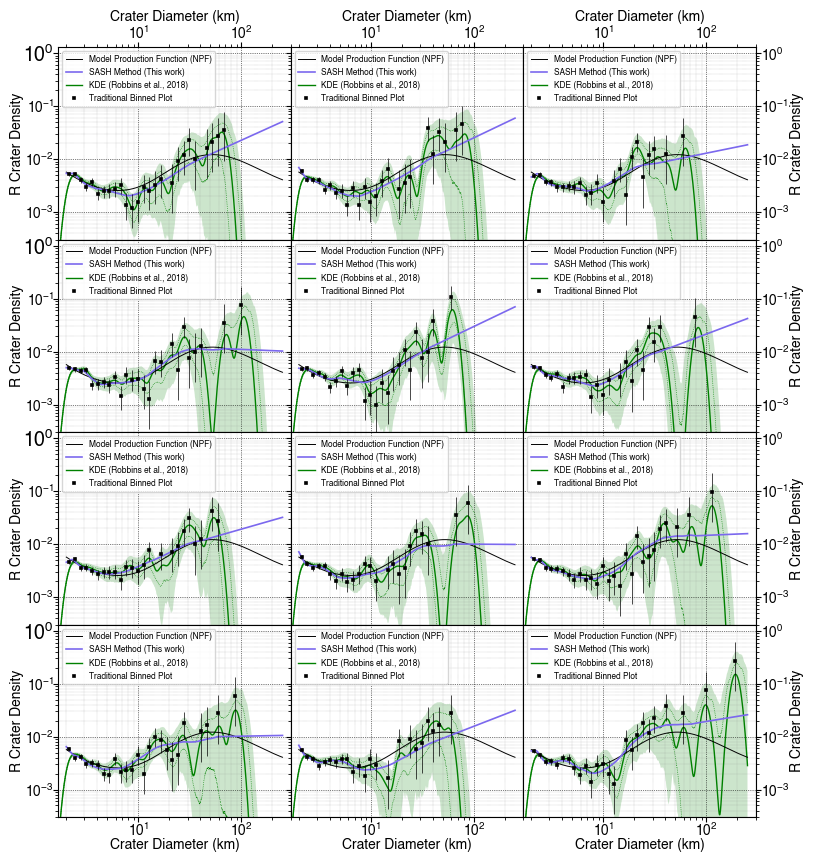

In [70]:
fig = plt.figure(figsize=(9, 10))

def sash_comparison_R_plot(i):

    ds = synth_d_list[0][i]

    plot_kde_R(
        ds, area, d_min=1.0, d_max=dmax, color='green', 
        lw=1.0, plot_error=True, n_synths=1000
    )
    plot_npf_R_N(
        ds.size, area, dmin=dmin, dmax=dmax,
        lw=0.7, color='black'
    )
    X, mean_Y = plot_sash_R(
        ds, area, dmin, 
        bin_width_exponent=per_decade(18), 
        d_max=dmax, 
        growth_rate=1.3, n_points=10000, n_shifts=200,
        color='mediumslateblue', plot_lines=False, lw=1.2,
        line_color='mediumslateblue', line_lw=0.2,
        min_count=1, n_iterations=5,
        n_alpha_points=1000, plot_error=False
    )
    plot_R(
        ds, area, bin_width_exponent=per_decade(18),
        d_min=dmin, d_max=1E4, min_count=0, ms=2,
        fontsize=10
    )
    plt.xlim([dmin / 1.2, dmax * 1.2])
    plt.ylim([3E-4, 1.3E0])
    np.flip(np.sort(ds))[:10]
    
    lines = plt.gca().get_lines()
    
    plt.legend(
        [lines[i] for i in [3, 4, 0, 5]], 
        [
            'Model Production Function (NPF)',
            'SASH Method (This work)',
            'KDE (Robbins et al., 2018)',
            'Traditional Binned Plot'
        ], 
        fontsize=6, loc='upper left'
    )

    ax = plt.gca()
    if i % 3 == 0:
        ax.yaxis.labelpad = -1
    if i % 3 == 1:
        ax.set_ylabel(None)
        ax.tick_params(axis='y', which='both', labelleft=False)
    if i % 3 == 2:
        ax.yaxis.labelpad = 1
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    if i < 3:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.xaxis.labelpad = 3
    if i > 8:
        ax.xaxis.labelpad = -1
        
    ax.tick_params(axis='both', which='major', pad=0)
    plt.xlim
    
    # add_letter()

for i in range(12):
    fig.add_subplot(4, 3, i + 1)
    sash_comparison_R_plot(i)

plt.subplots_adjust(wspace=0, hspace=0)
f = 'figs/sash_synths_figure.pdf'
plt.gcf().savefig(f, bbox_inches='tight')

0.41817 seconds


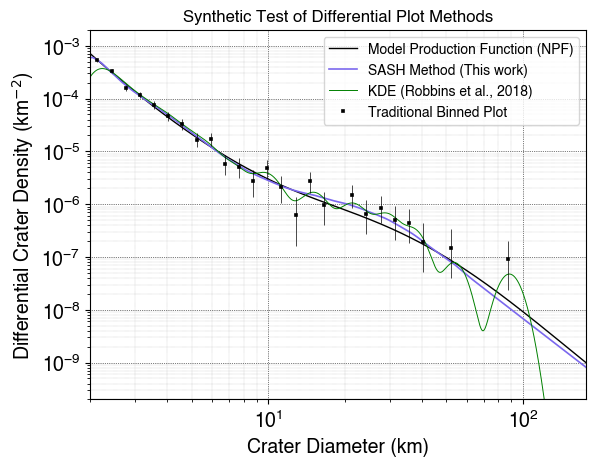

In [4]:
plot_npf_dif_N(
    ds.size, area, dmin=dmin, lw=1, color='black'
)
X, mean_Y = plot_sash(
    ds, area, dmin, 
    bin_width_exponent=per_decade(18), 
    d_max=10 * np.max(ds), 
    growth_rate=1.3, n_points=10000, n_shifts=200,
    color='mediumslateblue', plot_lines=False, lw=1.2,
    line_color='mediumslateblue', line_lw=0.2,
    min_count=1, n_iterations=5,
    n_alpha_points=1000, plot_error=False
)
plot_kde(ds, area, d_min=1.0, color='green', lw=0.7)
plot_differential(
    ds, area, bin_width_exponent=per_decade(18),
    d_min=dmin, d_max=1E4, min_count=0, ms=2
)
plt.xlim([dmin, 2 * np.max(ds)])
plt.ylim([2E-10, 2E-3])
np.flip(np.sort(ds))[:10]

lines = plt.gca().get_lines()

plt.legend(lines, [
    'Model Production Function (NPF)',
    'SASH Method (This work)',
    'KDE (Robbins et al., 2018)',
    'Traditional Binned Plot'
])

plt.title('Synthetic Test of Differential Plot Methods')
# plt.xlim([2, 7])
# plt.ylim([1E-2, 9E-1])
plt.gcf().savefig('figs/sash_test.pdf', bbox_inches='tight')

Calculation time: 0.00012 seconds


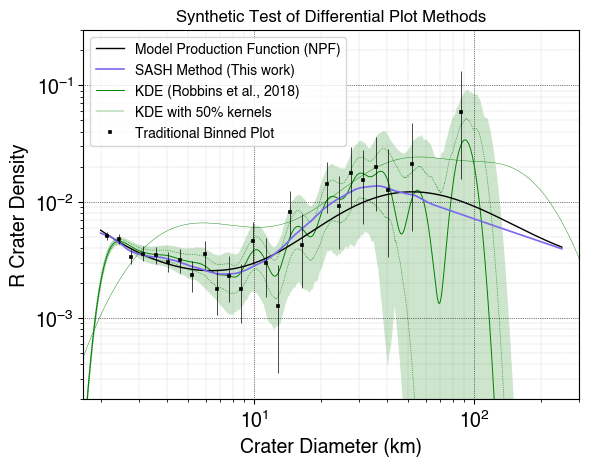

In [13]:
plot_kde_R(
    ds, area, d_min=1.0, color='green', lw=0.7,
    plot_error=True
)
plot_npf_R_N(
    ds.size, area, dmin=dmin, lw=1, color='black',
    dmax=dmax
)
X, mean_Y = plot_sash_R(
    ds, area, dmin, 
    bin_width_exponent=per_decade(18), 
    d_max=dmax, growth_rate=1.3, n_points=10000, 
    n_shifts=200, color='mediumslateblue', lw=1.2, min_count=1,
    n_iterations=5, n_alpha_points=1000, plot_error=False
)
plot_kde_R(ds, area, d_min=1.0, color='green', lw=0.3, factor=1.5)
plot_R(
    ds, area, bin_width_exponent=per_decade(18),
    d_min=dmin, d_max=1E4, min_count=0, ms=2
)
plt.xlim([dmin / 1.2, dmax * 1.2])
plt.ylim([2E-4, 3E-1])
np.flip(np.sort(ds))[:10]

lines = plt.gca().get_lines()

plt.legend(
    [lines[i] for i in [3, 4, 0, 5, 6]], 
    [
        'Model Production Function (NPF)',
        'SASH Method (This work)',
        'KDE (Robbins et al., 2018)',
        'KDE with 50% kernels',
        'Traditional Binned Plot'
    ], 
    loc='upper left'
)

plt.title('Synthetic Test of Differential Plot Methods')
# plt.xlim([2, 7])
# plt.ylim([1E-2, 9E-1])
plt.gcf().savefig('figs/sash_test_R.pdf', bbox_inches='tight')